In [9]:
import os
import re
import glob
import gzip
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

```bash
wget https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_43/gencode.v43.long_noncoding_RNAs.gtf.gz
wget https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_43/gencode.v43.annotation.gtf.gz
wget https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_43/GRCh38.primary_assembly.genome.fa.gz
wget https://ftp.ebi.ac.uk/pub/databases/RNAcentral/current_release/id_mapping/id_mapping.tsv.gz
wget https://ftp.ebi.ac.uk/pub/databases/RNAcentral/current_release/genome_coordinates/
wget https://ngdc.cncb.ac.cn/lncbook/files/LncBookv2.0_GENCODEv34_GRCh38.gtf.gz
wget http://hollywood.mit.edu/burgelab/maxent/download/fordownload.tar.gz
```

・maxentscan  : https://github.com/kepbod/maxentpy

### 
```bash
# 1       RNAcentral      transcript      11868   14409   .       +       .       Name=URS00008C1902_9606;type=lncRNA;databases=GeneCards,LNCipedia,NONCODE;ID=URS00008C1902_9606.1;source=expert-database;providing_databases=LNCipedia
```
```bash
# chr1    HAVANA  transcript      12010   13670   .       +       .       gene_id "ENSG00000223972.5"; transcript_id "ENST00000450305.2"; gene_type "transcribed_unprocessed_pseudogene"; gene_name "DDX11L1"; transcript_type "transcribed_unprocessed_pseudogene"; transcript_name "DDX11L1-201"; level 2; transcript_support_level "NA"; hgnc_id "HGNC:37102"; ont "PGO:0000005"; ont "PGO:0000019"; tag "basic"; havana_gene "OTTHUMG00000000961.2"; havana_transcript "OTTHUMT00000002844.2";
```

In [ ]:
# RNA central -> GeneName linked CentralID


In [4]:
# RNAcentral -> lncRNA

infile = '/Users/tomoyauchiyama/lncRNA/reference/homo_sapiens.GRCh38.gff3.gz'
outfile = '/Users/tomoyauchiyama/lncRNA/reference/homo_sapiens.GRCh38_lncRNA.gff3'

with open(outfile, 'w') as wf:
    with gzip.open(infile, 'rt') as gff3:
        for line in gff3.readlines():
            tmp = line
            line = line.rstrip('\n').split()
            if '#' in line[0]:
                pass
            else:
                ele = line[-1].split(';')
                if ele[1] == 'type=lncRNA':
                    wf.write(f'{tmp}\n')

```bash
touchiyama:09:53:38:@Mac:~/lncRNA/reference $ zless gencode.v43.long_noncoding_RNAs.gtf.gz | grep -v '#'| cut -f3 | sort | uniq -c
217900 exon
19928 gene
58023 transcript
```
```bash
touchiyama:09:49:33:@Mac:~/lncRNA/reference $ zless LncBookv2.0_GENCODEv34_GRCh38.gtf.gz | cut -f3 | sort | uniq -c
762308 CDS
 115 Selenocysteine
311130 UTR
2192343 exon
139013 gene
87642 start_codon
80001 stop_codon
504274 transcript
```
```bash
touchiyama:09:48:54:@Mac:~/lncRNA/reference $ less homo_sapiens.GRCh38_lncRNA.gff3 | cut -f3 | sort | uniq -c
3039222
2277487 noncoding_exon
761735 transcript
```

In [41]:
# exon1-exon2 splice site in lncRNA
# LncBookv2.0_GENCODE_GRCh38.gtf.gz

infile = '/Users/tomoyauchiyama/lncRNA/reference/LncBookv2.0_GENCODEv34_GRCh38.gtf.gz'
exon_info = {}
with gzip.open(infile, 'rt') as gtf:
    for line in gtf.readlines():
        line = line.rstrip('\n').split('\t')
        if '#' in line[0]:
            pass
        else:
            if line[2] == 'transcript':
                flag = 0
                for ele in line[-1].split('; '):
                    if 'transcript_id' in ele:
                        transcript_id = re.search(r'transcript_id \"(.*)\"', ele).group(1)
                    if 'gene_type' in ele:
                        gene_type = re.search(r'gene_type \"(.*)\"', ele).group(1)
                    if 'transcript_type' in ele:
                        transcript_type = re.search(r'transcript_type \"(.*)\"', ele).group(1)
                if (gene_type == 'lncRNA') & (transcript_type == 'lncRNA'):
                    flag = 1
            elif line[2] == 'exon':
                if flag == 1:
                    chrom = line[0]
                    strand = line[6]
                    start = line[3]
                    end = line[4]
                    exon = chrom + ':' + start + '-' + end
                    tx_id = transcript_id + ',' + strand
                    if exon_info.get(tx_id):
                        exon_info[tx_id] += ',' + exon
                    else:
                        exon_info[tx_id] = exon


In [43]:
len(exon_info)

323950

In [55]:
# test
# l = ['chr1:96600-96810', 'chr1:106636-107727']
# print(l)
# print(sorted(l))
# print(sorted(l, key=lambda s: int(re.search(r'.*:(\d+)-\d+', s).group(1))))

['chr1:96600-96810', 'chr1:106636-107727']
['chr1:106636-107727', 'chr1:96600-96810']
['chr1:96600-96810', 'chr1:106636-107727']


In [58]:
# genome
fasta = '/Users/tomoyauchiyama/lncRNA/reference/GRCh38.primary_assembly.genome.fa.gz'
dna = {}
with gzip.open(infile, 'rt') as fa:
    for line in fa.readlines():
        line = line.rstrip('\n')
        if re.compile(r'^>').search(line):
            tmp = line.split()
            m = re.compile(r'^>(.*)').search(tmp[0])
            chrom = m.group(1)
        else:
            if dna.get(chrom):
                dna[chrom] += line
            else:
                dna[chrom] = line

KeyboardInterrupt: 

In [63]:
outfile = '/Users/tomoyauchiyama/lncRNA/maxentpy/LncBookv2.0_lncRNA/LncBookv2.0_lncRNA_SS.txt'

with open(outfile, 'w') as wf:
    wf.write('# transcript_id\tchr\tstrand\texon1\texon2\t5SS_start\t5SS_end\t3SS_start\t3SS_end\t5SS_seq\t3SS_seq\n')
    for tx_id, exon in exon_info.items():
        transcript_id, strand = tx_id.split(',')
        ex_list = exon.split(',')
        exons = sorted(ex_list, key=lambda s: int(re.search(r'.*:(\d+)-\d+', s).group(1)))
        if len(exons) > 1:
            if strand == '+':
                exon1 = exons[0]
                exon2 = exons[1]

                exon1_info = re.search(r'(.*):\d+-(\d+)', exon1)
                chrom = exon1_info.group(1)
                pos = int(exon1_info.group(2))
                five_ss_start = str(pos - 3)
                five_ss_end = str(pos + 6)
                #five_ss = chrom + ':' + five_ss_start + '-' + five_ss_end
                #five_ss_seq = dna[chrom][int(five_ss_start)-1:int(five_ss_end)]

                exon2_info = re.search(r'(.*):(\d+)-\d+', exon2)
                chrom = exon2_info.group(1)
                pos = int(exon2_info.group(2))
                three_ss_start = str((pos - 1) - 20)
                three_ss_end = str((pos - 1) + 3)
                #three_ss = chrom + ':' + three_ss_start + '-' + three_ss_end
                #three_ss_seq = dna[chrom][int(three_ss_start)-1:int(three_ss_end)]

            elif strand == '-':
                exon1 = exons[-1]
                exon2 = exons[-2]

                exon1_info = re.search(r'(.*):(\d+)-\d+', exon1)
                chrom = exon1_info.group(1)
                pos = int(exon1_info.group(2))
                five_ss_start = str((pos - 1) - 6)
                five_ss_end = str((pos - 1) + 3)
                #five_ss = chrom + ':' + five_ss_start + '-' + five_ss_end
                #five_ss_seq = dna[chrom][int(five_ss_start)-1:int(five_ss_end)]
                #five_ss_seq = five_ss_seq[::-1]
                #five_ss_seq = five_ss_seq.translate(nucl.maketrans('ATGC', 'TACG'))

                exon2_info = re.search(r'(.*):\d+-(\d+)', exon2)
                chrom = exon2_info.group(1)
                pos = int(exon2_info.group(2))
                three_ss_start = str(pos - 3)
                three_ss_end = str(pos + 20)
                #three_ss = chrom + ':' + three_ss_start + '-' + three_ss_end
                #three_ss_seq = dna[chrom][int(three_ss_start)-1:int(three_ss_end)]
                #three_ss_seq = three_ss_seq[::-1]
                #three_ss_seq = three_ss_seq.translate(nucl.maketrans('ATGC', 'TACG'))

            #wf.write(f'{transcript_id}\t{strand}\t{exon1}\t{exon2}\t{five_ss}\t{three_ss}\n')
            #wf.write(f'{transcript_id}\t{chrom}\t{strand}\t{exon1}\t{exon2}\t{five_ss_start}\t{five_ss_end}\t{three_ss_start}\t{three_ss_end}\t{five_ss_seq}\t{three_ss_seq}\n')
            wf.write(f'{transcript_id}\t{chrom}\t{strand}\t{exon1}\t{exon2}\t{five_ss_start}\t{five_ss_end}\t{three_ss_start}\t{three_ss_end}\n')

In [ ]:
```bash
pip install pybedtools
```
#from pybedtools import BedTool

#file = '/Users/tomoyauchiyama/lncRNA/reference/LncBookv2.0_lncRNA_SS.txt'
#df5 = pd.read_csv(file, sep='\t')
#b = BedTool.from_dataframe(df5[['chr', 'five_ss_start', 'five_ss_end', 'transcript_id', 'strand']])
#b.sequence(
#    fi='/Users/tomoyauchiyama/lncRNA/reference/GRCh38.primary_assembly.genome.fa.gz',
#    s=True,
#    fo='/Users/tomoyauchiyama/lncRNA/reference/LncBookv2.0_lncRNA_5SS.fa'
#)

```bash
# 5' splice site
touchiyama:15:29:45:@Mac:~/lncRNA/maxentpy/LncBookv2.0_lncRNA $ cut -f1,2,3,6,7 LncBookv2.0_lncRNA_SS.txt |grep -v '#' |awk '$3=="+"{print $2 "\t" $4 "\t" $5 "\t" $1","$3  "\t" $3}' > ./LncBookv2.0_lncRNA_5SS.p.bed
touchiyama:15:31:01:@Mac:~/lncRNA/maxentpy/LncBookv2.0_lncRNA $ seqkit subseq --bed ./LncBookv2.0_lncRNA_5SS.p.bed ../../reference/GRCh38.primary_assembly.genome.fa.gz > LncBookv2.0_lncRNA_5SS.p.fa
[INFO] read BED file ...
[INFO] 146852 BED features loaded

touchiyama:15:30:47:@Mac:~/lncRNA/maxentpy/LncBookv2.0_lncRNA $ cut -f1,2,3,6,7 LncBookv2.0_lncRNA_SS.txt |grep -v '#' |awk '$3=="-"{print $2 "\t" $4 "\t" $5 "\t" $1","$3  "\t" $3}' > ./LncBookv2.0_lncRNA_5SS.m.bed
touchiyama:16:11:13:@Mac:~/lncRNA/maxentpy/LncBookv2.0_lncRNA $ seqkit subseq --bed ./LncBookv2.0_lncRNA_5SS.m.bed ../../reference/GRCh38.primary_assembly.genome.fa.gz |seqkit seq -t dna -p -r - > LncBookv2.0_lncRNA_5SS.m.rv.fa
[INFO] when flag -t (--seq-type) given, flag -v (--validate-seq) is automatically switched on
[INFO] read BED file ...
[INFO] 139863 BED features loaded

touchiyama:16:12:54:@Mac:~/lncRNA/maxentpy/LncBookv2.0_lncRNA $ cat LncBookv2.0_lncRNA_5SS.p.fa LncBookv2.0_lncRNA_5SS.m.rv.fa > LncBookv2.0_lncRNA_5SS.fa
```

```bash
# 3' splice site
touchiyama:16:42:11:@Mac:~/lncRNA/maxentpy/LncBookv2.0_lncRNA $ cut -f1,2,3,8,9 LncBookv2.0_lncRNA_SS.txt |grep -v '#' |awk '$3=="+"{print $2 "\t" $4 "\t" $5 "\t" $1","$3  "\t" $3}' > ./LncBookv2.0_lncRNA_3SS.p.bed
touchiyama:16:42:14:@Mac:~/lncRNA/maxentpy/LncBookv2.0_lncRNA $ seqkit subseq --bed ./LncBookv2.0_lncRNA_3SS.p.bed ../../reference/GRCh38.primary_assembly.genome.fa.gz > LncBookv2.0_lncRNA_3SS.p.fa
[INFO] read BED file ...
[INFO] 146852 BED features loaded

touchiyama:16:42:11:@Mac:~/lncRNA/maxentpy/LncBookv2.0_lncRNA $ cut -f1,2,3,8,9 LncBookv2.0_lncRNA_SS.txt |grep -v '#' |awk '$3=="-"{print $2 "\t" $4 "\t" $5 "\t" $1","$3  "\t" $3}' > ./LncBookv2.0_lncRNA_3SS.m.bed
touchiyama:16:49:06:@Mac:~/lncRNA/maxentpy/LncBookv2.0_lncRNA $ seqkit subseq --bed ./LncBookv2.0_lncRNA_3SS.m.bed ../../reference/GRCh38.primary_assembly.genome.fa.gz |seqkit seq -t dna -p -r - > LncBookv2.0_lncRNA_3SS.m.rv.fa
[INFO] when flag -t (--seq-type) given, flag -v (--validate-seq) is automatically switched on
[INFO] read BED file ...
[INFO] 139863 BED features loaded

touchiyama:16:12:54:@Mac:~/lncRNA/maxentpy $ cat LncBookv2.0_lncRNA_3SS.p.fa LncBookv2.0_lncRNA_3SS.m.rv.fa > LncBookv2.0_lncRNA_3SS.fa
```

```bash
# Run MaxEntScan tool
touchiyama:16:55:42:@Mac:~/lncRNA/maxentpy/fordownload $ cp ../LncBookv2.0_lncRNA/LncBookv2.0_lncRNA_*SS.fa .
touchiyama:16:55:42:@Mac:~/lncRNA/maxentpy/fordownload $ perl score5.pl LncBookv2.0_lncRNA_5SS.fa > /Users/tomoyauchiyama/lncRNA/maxentpy/LncBookv2.0_lncRNA/LncBookv2.0_lncRNA_score5.txt
touchiyama:16:57:48:@Mac:~/lncRNA/maxentpy/fordownload $ perl score3.pl LncBookv2.0_lncRNA_3SS.fa > /Users/tomoyauchiyama/lncRNA/maxentpy/LncBookv2.0_lncRNA/LncBookv2.0_lncRNA_score3.txt
```

In [92]:
file = '/Users/tomoyauchiyama/lncRNA/maxentpy/LncBookv2.0_lncRNA/LncBookv2.0_lncRNA_score5.txt'
df5 = pd.read_csv(file, sep='\t', header=None)
df_split = df5[0].str.split(' ', expand=True)
df5 = pd.concat([df_split, df5[[1, 2]]], axis=1)
df5.columns = ['pos', 'ID' , '5ss_seq', '5ss_score']

file = '/Users/tomoyauchiyama/lncRNA/maxentpy/LncBookv2.0_lncRNA/LncBookv2.0_lncRNA_score3.txt'
df3 = pd.read_csv(file, sep='\t', header=None)
df_split = df3[0].str.split(' ', expand=True)
df3 = pd.concat([df_split, df3[[1, 2]]], axis=1)
df3.columns = ['pos', 'ID' , '3ss_seq', '3ss_score']

df_merge = pd.merge(df5, df3, how='left', on='ID')

df_ID = df_merge['ID'].str.split(',', expand=True)
df_ID.columns = ['transcript_id', 'strand']
df_ss_score = pd.concat([df_ID, df_merge.drop(columns='ID')], axis=1)

df_LncBook = df_ss_score

In [93]:
df_LncBook.head()


,transcript_id,strand,pos_x,5ss_seq,5ss_score,pos_y,3ss_seq,3ss_score
0,HSALNT0000008,+,chr1_30037-30045:.,TGGGTAGAG,-1.16,chr1_30544-30566:.,ACACTCTCTCCCTCTCCCAGTTT,9.51
1,HSALNT0000010,+,chr1_30665-30673:.,GAGGTAAAG,8.27,chr1_30956-30978:.,CTCTGTCTTTTCCCACCAAGTGA,4.48
2,HSALNT0289525,+,chr1_30037-30045:.,TGGGTAGAG,-1.16,chr1_30544-30566:.,ACACTCTCTCCCTCTCCCAGTTT,9.51
3,HSALNT0289527,+,chr1_51992-52000:.,TGGGTGAGT,8.73,chr1_53262-53284:.,TTGCTATCACCCCTGTCTAGGAT,7.70
4,HSALNT0289534,+,chr1_96808-96816:.,GGAGTAAGT,8.57,chr1_106616-106638:.,TATGTTTTCCCCTAACTCAGGGT,7.34


In [94]:
# exon1-exon2 splice site in mRNA
# encode.v43.annotation.gtf.gz

infile = '/Users/tomoyauchiyama/lncRNA/reference/gencode.v43.annotation.gtf.gz'
exon_info = {}
with gzip.open(infile, 'rt') as gtf:
    for line in gtf.readlines():
        line = line.rstrip('\n').split('\t')
        if '#' in line[0]:
            pass
        else:
            if line[2] == 'transcript':
                flag = 0
                for ele in line[-1].split('; '):
                    if 'transcript_id' in ele:
                        transcript_id = re.search(r'transcript_id \"(.*)\"', ele).group(1)
                    if 'gene_type' in ele:
                        gene_type = re.search(r'gene_type \"(.*)\"', ele).group(1)
                    if 'transcript_type' in ele:
                        transcript_type = re.search(r'transcript_type \"(.*)\"', ele).group(1)
                if (gene_type == 'protein_coding') & (transcript_type == 'protein_coding'):
                    flag = 1
            elif line[2] == 'exon':
                if flag == 1:
                    chrom = line[0]
                    strand = line[6]
                    start = line[3]
                    end = line[4]
                    exon = chrom + ':' + start + '-' + end
                    tx_id = transcript_id + ',' + strand
                    if exon_info.get(tx_id):
                        exon_info[tx_id] += ',' + exon
                    else:
                        exon_info[tx_id] = exon


In [95]:
len(exon_info)

89411

In [96]:
#gencode.v43.mRNA/
outfile = '/Users/tomoyauchiyama/lncRNA/maxentpy/gencode.v43.mRNA/gencode_v43_mRNA_SS.txt'

with open(outfile, 'w') as wf:
    wf.write('# transcript_id\tchr\tstrand\texon1\texon2\t5SS_start\t5SS_end\t3SS_start\t3SS_end\t5SS_seq\t3SS_seq\n')
    for tx_id, exon in exon_info.items():
        transcript_id, strand = tx_id.split(',')
        ex_list = exon.split(',')
        exons = sorted(ex_list, key=lambda s: int(re.search(r'.*:(\d+)-\d+', s).group(1)))
        if len(exons) > 1:
            if strand == '+':
                exon1 = exons[0]
                exon2 = exons[1]

                exon1_info = re.search(r'(.*):\d+-(\d+)', exon1)
                chrom = exon1_info.group(1)
                pos = int(exon1_info.group(2))
                five_ss_start = str(pos - 3)
                five_ss_end = str(pos + 6)
                #five_ss = chrom + ':' + five_ss_start + '-' + five_ss_end
                #five_ss_seq = dna[chrom][int(five_ss_start)-1:int(five_ss_end)]

                exon2_info = re.search(r'(.*):(\d+)-\d+', exon2)
                chrom = exon2_info.group(1)
                pos = int(exon2_info.group(2))
                three_ss_start = str((pos - 1) - 20)
                three_ss_end = str((pos - 1) + 3)
                #three_ss = chrom + ':' + three_ss_start + '-' + three_ss_end
                #three_ss_seq = dna[chrom][int(three_ss_start)-1:int(three_ss_end)]

            elif strand == '-':
                exon1 = exons[-1]
                exon2 = exons[-2]

                exon1_info = re.search(r'(.*):(\d+)-\d+', exon1)
                chrom = exon1_info.group(1)
                pos = int(exon1_info.group(2))
                five_ss_start = str((pos - 1) - 6)
                five_ss_end = str((pos - 1) + 3)
                #five_ss = chrom + ':' + five_ss_start + '-' + five_ss_end
                #five_ss_seq = dna[chrom][int(five_ss_start)-1:int(five_ss_end)]
                #five_ss_seq = five_ss_seq[::-1]
                #five_ss_seq = five_ss_seq.translate(nucl.maketrans('ATGC', 'TACG'))

                exon2_info = re.search(r'(.*):\d+-(\d+)', exon2)
                chrom = exon2_info.group(1)
                pos = int(exon2_info.group(2))
                three_ss_start = str(pos - 3)
                three_ss_end = str(pos + 20)
                #three_ss = chrom + ':' + three_ss_start + '-' + three_ss_end
                #three_ss_seq = dna[chrom][int(three_ss_start)-1:int(three_ss_end)]
                #three_ss_seq = three_ss_seq[::-1]
                #three_ss_seq = three_ss_seq.translate(nucl.maketrans('ATGC', 'TACG'))

            #wf.write(f'{transcript_id}\t{strand}\t{exon1}\t{exon2}\t{five_ss}\t{three_ss}\n')
            #wf.write(f'{transcript_id}\t{chrom}\t{strand}\t{exon1}\t{exon2}\t{five_ss_start}\t{five_ss_end}\t{three_ss_start}\t{three_ss_end}\t{five_ss_seq}\t{three_ss_seq}\n')
            wf.write(f'{transcript_id}\t{chrom}\t{strand}\t{exon1}\t{exon2}\t{five_ss_start}\t{five_ss_end}\t{three_ss_start}\t{three_ss_end}\n')

```bash
# 5' splice site
touchiyama:17:40:34:@Mac:~/lncRNA/maxentpy/gencode.v43.mRNA $ cut -f1,2,3,6,7 gencode_v43_mRNA_SS.txt |grep -v '#' |awk '$3=="+"{print $2 "\t" $4 "\t" $5 "\t" $1","$3  "\t" $3}' > ./gencode_v43_mRNA_5SS.p.bed
touchiyama:17:41:07:@Mac:~/lncRNA/maxentpy/gencode.v43.mRNA $ seqkit subseq --bed ./gencode_v43_mRNA_5SS.p.bed ../../reference/GRCh38.primary_assembly.genome.fa.gz > gencode_v43_mRNA_5SS.p.fa
[INFO] read BED file ...
[INFO] 44655 BED features loaded

touchiyama:17:42:40:@Mac:~/lncRNA/maxentpy/gencode.v43.mRNA $ cut -f1,2,3,6,7 gencode_v43_mRNA_SS.txt |grep -v '#' |awk '$3=="-"{print $2 "\t" $4 "\t" $5 "\t" $1","$3  "\t" $3}' > ./gencode_v43_mRNA_5SS.m.bed
touchiyama:17:44:35:@Mac:~/lncRNA/maxentpy/gencode.v43.mRNA $ seqkit subseq --bed ./gencode_v43_mRNA_5SS.m.bed ../../reference/GRCh38.primary_assembly.genome.fa.gz |seqkit seq -t dna -p -r - > ./gencode_v43_mRNA_5SS.m.rv.fa
[INFO] when flag -t (--seq-type) given, flag -v (--validate-seq) is automatically switched on
[INFO] read BED file ...
[INFO] 43266 BED features loaded

touchiyama:17:45:05:@Mac:~/lncRNA/maxentpy/gencode.v43.mRNA $ cat ./gencode_v43_mRNA_5SS.p.fa ./gencode_v43_mRNA_5SS.m.rv.fa > ./gencode_v43_mRNA_5SS.fa
```

```bash
# 3' splice site
touchiyama:17:47:01:@Mac:~/lncRNA/maxentpy/gencode.v43.mRNA $ cut -f1,2,3,8,9 gencode_v43_mRNA_SS.txt |grep -v '#' |awk '$3=="+"{print $2 "\t" $4 "\t" $5 "\t" $1","$3  "\t" $3}' > ./gencode_v43_mRNA_3SS.p.bed
touchiyama:17:47:46:@Mac:~/lncRNA/maxentpy/gencode.v43.mRNA $ seqkit subseq --bed ./gencode_v43_mRNA_3SS.p.bed ../../reference/GRCh38.primary_assembly.genome.fa.gz > ./gencode_v43_mRNA_3SS.p.fa
[INFO] read BED file ...
[INFO] 44655 BED features loaded

touchiyama:17:48:41:@Mac:~/lncRNA/maxentpy/gencode.v43.mRNA $ cut -f1,2,3,8,9 gencode_v43_mRNA_SS.txt |grep -v '#' |awk '$3=="-"{print $2 "\t" $4 "\t" $5 "\t" $1","$3  "\t" $3}' > ./gencode_v43_mRNA_3SS.m.bed
touchiyama:17:51:25:@Mac:~/lncRNA/maxentpy/gencode.v43.mRNA $ seqkit subseq --bed ./gencode_v43_mRNA_3SS.m.bed ../../reference/GRCh38.primary_assembly.genome.fa.gz |seqkit seq -t dna -p -r - > ./gencode_v43_mRNA_3SS.m.rv.fa
[INFO] when flag -t (--seq-type) given, flag -v (--validate-seq) is automatically switched on
[INFO] read BED file ...
[INFO] 43266 BED features loaded

touchiyama:17:53:36:@Mac:~/lncRNA/maxentpy/gencode.v43.mRNA $ cat ./gencode_v43_mRNA_3SS.p.fa ./gencode_v43_mRNA_3SS.m.rv.fa > ./gencode_v43_mRNA_3SS.fa
```

```bash
# Run MaxEntScan tool
touchiyama:16:55:42:@Mac:~/lncRNA/maxentpy/fordownload $ cp ../gencode.v43.mRNA/gencode_v43_mRNA_*SS.fa .
touchiyama:17:56:36:@Mac:~/lncRNA/maxentpy/fordownload $ perl score5.pl gencode_v43_mRNA_5SS.fa > /Users/tomoyauchiyama/lncRNA/maxentpy/gencode.v43.mRNA/gencode_v43_mRNA_score5.txt
touchiyama:16:57:48:@Mac:~/lncRNA/maxentpy/fordownload $ perl score3.pl gencode_v43_mRNA_3SS.fa > /Users/tomoyauchiyama/lncRNA/maxentpy/gencode.v43.mRNA/gencode_v43_mRNA_score3.txt
```

In [97]:
file = '/Users/tomoyauchiyama/lncRNA/maxentpy/gencode.v43.mRNA/gencode_v43_mRNA_score5.txt'
df5 = pd.read_csv(file, sep='\t', header=None)
df_split = df5[0].str.split(' ', expand=True)
df5 = pd.concat([df_split, df5[[1, 2]]], axis=1)
df5.columns = ['pos', 'ID' , '5ss_seq', '5ss_score']

file = '/Users/tomoyauchiyama/lncRNA/maxentpy/gencode.v43.mRNA/gencode_v43_mRNA_score3.txt'
df3 = pd.read_csv(file, sep='\t', header=None)
df_split = df3[0].str.split(' ', expand=True)
df3 = pd.concat([df_split, df3[[1, 2]]], axis=1)
df3.columns = ['pos', 'ID' , '3ss_seq', '3ss_score']

df_merge = pd.merge(df5, df3, how='left', on='ID')

df_ID = df_merge['ID'].str.split(',', expand=True)
df_ID.columns = ['transcript_id', 'strand']
df_ss_score = pd.concat([df_ID, df_merge.drop(columns='ID')], axis=1)

df_gencode_mRNA = df_ss_score

In [98]:
df_gencode_mRNA.head()

,transcript_id,strand,pos_x,5ss_seq,5ss_score,pos_y,3ss_seq,3ss_score
0,ENST00000641515.2,+,chr1_65431-65439:.,CAGGTACAT,7.79,chr1_65500-65522:.,TACATATTATTCTCTTACAGTTT,9.11
1,ENST00000616016.5,+,chr1_924946-924954:.,AAGGTGCCG,5.74,chr1_925902-925924:.,TGCCTCGGCTCTGCTCGCAGGGA,9.26
2,ENST00000618323.5,+,chr1_924946-924954:.,AAGGTGCCG,5.74,chr1_925902-925924:.,TGCCTCGGCTCTGCTCGCAGGGA,9.26
3,ENST00000437963.5,+,chr1_925187-925195:.,AAGGTCTCT,0.90,chr1_925902-925924:.,TGCCTCGGCTCTGCTCGCAGGGA,9.26
4,ENST00000342066.8,+,chr1_925798-925806:.,GAGGTGGGT,7.07,chr1_925902-925924:.,TGCCTCGGCTCTGCTCGCAGGGA,9.26


In [99]:
df_LncBook.head()

,transcript_id,strand,pos_x,5ss_seq,5ss_score,pos_y,3ss_seq,3ss_score
0,HSALNT0000008,+,chr1_30037-30045:.,TGGGTAGAG,-1.16,chr1_30544-30566:.,ACACTCTCTCCCTCTCCCAGTTT,9.51
1,HSALNT0000010,+,chr1_30665-30673:.,GAGGTAAAG,8.27,chr1_30956-30978:.,CTCTGTCTTTTCCCACCAAGTGA,4.48
2,HSALNT0289525,+,chr1_30037-30045:.,TGGGTAGAG,-1.16,chr1_30544-30566:.,ACACTCTCTCCCTCTCCCAGTTT,9.51
3,HSALNT0289527,+,chr1_51992-52000:.,TGGGTGAGT,8.73,chr1_53262-53284:.,TTGCTATCACCCCTGTCTAGGAT,7.70
4,HSALNT0289534,+,chr1_96808-96816:.,GGAGTAAGT,8.57,chr1_106616-106638:.,TATGTTTTCCCCTAACTCAGGGT,7.34


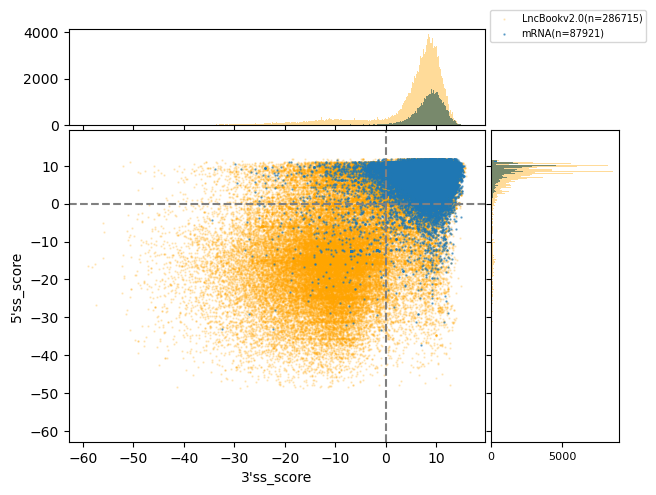

In [161]:
# 分布を確認

left, width = 0.1, 0.65 #散布図の左余白と、幅を定義
bottom, height = 0.1, 0.65 #散布図の下余白と、高さを定義
spacing = 0.01 #散布図とヒストグラムの間隔
fig_scatter = [left, bottom, width, height] #散布図の定義
fig_histx = [left, bottom + height + spacing, width, 0.2] #上のヒストグラムの定義
fig_histy = [left + width + spacing, bottom, 0.2, height] #右のヒストグラムの定義

fig = plt.figure() #描写領域を正方形で生成 figsize=(8, 8)

ax = fig.add_axes(fig_scatter) #図1として散布図領域を生成
ax_histx = fig.add_axes(fig_histx, sharex=ax) #上のヒストグラム領域を生成
ax_histy = fig.add_axes(fig_histy, sharey=ax) #右のヒストグラム領域を生成
ax_histx.tick_params(axis="x", labelbottom=False) #x軸ラベル無し
ax_histy.tick_params(axis="y", labelleft=False) #y軸ラベル無し

x1 = df_gencode_mRNA['3ss_score'].to_numpy()
y1 = df_gencode_mRNA['5ss_score'].to_numpy()
x2 = df_LncBook['3ss_score'].to_numpy()
y2 = df_LncBook['5ss_score'].to_numpy()

xmax = max(np.max(x1), np.max(x2))
ymax = max(np.max(y1), np.max(y2))
xymax = max(xmax, ymax)

xmin = min(np.min(x1), np.min(x2))
ymin = min(np.min(y1), np.min(y2))
xymin = min(xmin, ymin)

binwidth = 0.1 #binの値幅を定義。
bins = np.arange(xymin, xymax, binwidth) #binの個数を定義

#ax.set_xlim([0, xymax])
#ax.set_ylim([0, xymax])

ax.scatter(x2, y2, s=0.5, color='orange', alpha=0.2, label='LncBookv2.0(n='+str(len(x2))+')')
ax.scatter(x1, y1, s=0.5, color='#1f77b4', alpha=0.6, label='mRNA(n='+str(len(x1))+')')

#ax.plot([0, xymax], [0, xymax], color='darkturquoise', linestyle='--', label='FC=1')
#ax.plot(bins, 1.5*bins, color='dodgerblue', linestyle='--', label='FC=1.5')
#ax.plot(bins, 2.0*bins, color='blue', linestyle='--', label='FC=2')

#r = df.loc[:, x_label:y_label].corr(method='pearson').iloc[0, 1]
#lm = LinearRegression().fit(x.reshape(-1, 1), y)
#ax.plot(x, lm.predict(x.reshape(-1, 1)), color='purple', linestyle='--', label='r='+str(round(r, 2)))

ax_histx.hist(x1, bins=bins, color='#1f77b4')
ax_histy.hist(y1, bins=bins, orientation='horizontal', color='#1f77b4')
ax_histx.hist(x2, bins=bins, color='orange', alpha=0.4)
ax_histy.hist(y2, bins=bins, orientation='horizontal', color='orange', alpha=0.4)

ax.set_xlabel('3\'ss_score')
ax.set_ylabel('5\'ss_score')

ax.axvline(0, color='gray', linestyle='--')
ax.axhline(0, color='gray', linestyle='--')

ax.legend(
    bbox_to_anchor=(1.4, 1.4),
    loc='upper right',
    #borderaxespad=0,
    fontsize=7
)

plt.tick_params(labelsize=8)
plt.show()
#plt.savefig(outfile)

In [117]:
# exon1-exon2 splice site in lncRNA
# gencode.v43.long_noncoding_RNAs.gtf.gz

infile = '/Users/tomoyauchiyama/lncRNA/reference/gencode.v43.long_noncoding_RNAs.gtf.gz'
exon_info = {}
with gzip.open(infile, 'rt') as gtf:
    for line in gtf.readlines():
        line = line.rstrip('\n').split('\t')
        if '#' in line[0]:
            pass
        else:
            if line[2] == 'transcript':
                flag = 0
                for ele in line[-1].split('; '):
                    if 'transcript_id' in ele:
                        transcript_id = re.search(r'transcript_id \"(.*)\"', ele).group(1)
                    if 'gene_type' in ele:
                        gene_type = re.search(r'gene_type \"(.*)\"', ele).group(1)
                    if 'transcript_type' in ele:
                        transcript_type = re.search(r'transcript_type \"(.*)\"', ele).group(1)
                if (gene_type == 'lncRNA') & (transcript_type == 'lncRNA'):
                    flag = 1
            elif line[2] == 'exon':
                if flag == 1:
                    chrom = line[0]
                    strand = line[6]
                    start = line[3]
                    end = line[4]
                    exon = chrom + ':' + start + '-' + end
                    tx_id = transcript_id + ',' + strand
                    if exon_info.get(tx_id):
                        exon_info[tx_id] += ',' + exon
                    else:
                        exon_info[tx_id] = exon

In [118]:
len(exon_info)

56138

In [119]:
#gencode.v43.mRNA/
outfile = '/Users/tomoyauchiyama/lncRNA/maxentpy/gencode.v43.lncRNA/gencode_v43_lncRNA_SS.txt'

with open(outfile, 'w') as wf:
    wf.write('# transcript_id\tchr\tstrand\texon1\texon2\t5SS_start\t5SS_end\t3SS_start\t3SS_end\t5SS_seq\t3SS_seq\n')
    for tx_id, exon in exon_info.items():
        transcript_id, strand = tx_id.split(',')
        ex_list = exon.split(',')
        exons = sorted(ex_list, key=lambda s: int(re.search(r'.*:(\d+)-\d+', s).group(1)))
        if len(exons) > 1:
            if strand == '+':
                exon1 = exons[0]
                exon2 = exons[1]

                exon1_info = re.search(r'(.*):\d+-(\d+)', exon1)
                chrom = exon1_info.group(1)
                pos = int(exon1_info.group(2))
                five_ss_start = str(pos - 3)
                five_ss_end = str(pos + 6)
                #five_ss = chrom + ':' + five_ss_start + '-' + five_ss_end
                #five_ss_seq = dna[chrom][int(five_ss_start)-1:int(five_ss_end)]

                exon2_info = re.search(r'(.*):(\d+)-\d+', exon2)
                chrom = exon2_info.group(1)
                pos = int(exon2_info.group(2))
                three_ss_start = str((pos - 1) - 20)
                three_ss_end = str((pos - 1) + 3)
                #three_ss = chrom + ':' + three_ss_start + '-' + three_ss_end
                #three_ss_seq = dna[chrom][int(three_ss_start)-1:int(three_ss_end)]

            elif strand == '-':
                exon1 = exons[-1]
                exon2 = exons[-2]

                exon1_info = re.search(r'(.*):(\d+)-\d+', exon1)
                chrom = exon1_info.group(1)
                pos = int(exon1_info.group(2))
                five_ss_start = str((pos - 1) - 6)
                five_ss_end = str((pos - 1) + 3)
                #five_ss = chrom + ':' + five_ss_start + '-' + five_ss_end
                #five_ss_seq = dna[chrom][int(five_ss_start)-1:int(five_ss_end)]
                #five_ss_seq = five_ss_seq[::-1]
                #five_ss_seq = five_ss_seq.translate(nucl.maketrans('ATGC', 'TACG'))

                exon2_info = re.search(r'(.*):\d+-(\d+)', exon2)
                chrom = exon2_info.group(1)
                pos = int(exon2_info.group(2))
                three_ss_start = str(pos - 3)
                three_ss_end = str(pos + 20)
                #three_ss = chrom + ':' + three_ss_start + '-' + three_ss_end
                #three_ss_seq = dna[chrom][int(three_ss_start)-1:int(three_ss_end)]
                #three_ss_seq = three_ss_seq[::-1]
                #three_ss_seq = three_ss_seq.translate(nucl.maketrans('ATGC', 'TACG'))

            #wf.write(f'{transcript_id}\t{strand}\t{exon1}\t{exon2}\t{five_ss}\t{three_ss}\n')
            #wf.write(f'{transcript_id}\t{chrom}\t{strand}\t{exon1}\t{exon2}\t{five_ss_start}\t{five_ss_end}\t{three_ss_start}\t{three_ss_end}\t{five_ss_seq}\t{three_ss_seq}\n')
            wf.write(f'{transcript_id}\t{chrom}\t{strand}\t{exon1}\t{exon2}\t{five_ss_start}\t{five_ss_end}\t{three_ss_start}\t{three_ss_end}\n')

```bash
# 5' splice site
touchiyama:18:29:59:@Mac:~/lncRNA/maxentpy/gencode.v43.lncRNA $ cut -f1,2,3,6,7 gencode_v43_lncRNA_SS.txt |grep -v '#' |awk '$3=="+"{print $2 "\t" $4 "\t" $5 "\t" $1","$3  "\t" $3}' > ./gencode_v43_lncRNA_5SS.p.bed
touchiyama:18:31:20:@Mac:~/lncRNA/maxentpy/gencode.v43.lncRNA $ seqkit subseq --bed ./gencode_v43_lncRNA_5SS.p.bed ../../reference/GRCh38.primary_assembly.genome.fa.gz > gencode_v43_lncRNA_5SS.p.fa
[INFO] read BED file ...
[INFO] 27791 BED features loaded

touchiyama:18:32:06:@Mac:~/lncRNA/maxentpy/gencode.v43.lncRNA $ cut -f1,2,3,6,7 gencode_v43_lncRNA_SS.txt |grep -v '#' |awk '$3=="-"{print $2 "\t" $4 "\t" $5 "\t" $1","$3  "\t" $3}' > ./gencode_v43_lncRNA_5SS.m.bed
touchiyama:18:33:08:@Mac:~/lncRNA/maxentpy/gencode.v43.lncRNA $ seqkit subseq --bed ./gencode_v43_lncRNA_5SS.m.bed ../../reference/GRCh38.primary_assembly.genome.fa.gz |seqkit seq -t dna -p -r - > ./gencode_v43_lncRNA_5SS.m.rv.fa
[INFO] when flag -t (--seq-type) given, flag -v (--validate-seq) is automatically switched on
[INFO] read BED file ...
[INFO] 24370 BED features loaded

touchiyama:18:34:37:@Mac:~/lncRNA/maxentpy/gencode.v43.lncRNA $ cat ./gencode_v43_lncRNA_5SS.p.fa ./gencode_v43_lncRNA_5SS.m.rv.fa > ./gencode_v43_lncRNA_5SS.fa
```

```bash
# 3' splice site
touchiyama:18:35:18:@Mac:~/lncRNA/maxentpy/gencode.v43.lncRNA $ cut -f1,2,3,8,9 gencode_v43_lncRNA_SS.txt |grep -v '#' |awk '$3=="+"{print $2 "\t" $4 "\t" $5 "\t" $1","$3  "\t" $3}' > ./gencode_v43_lncRNA_3SS.p.bed
touchiyama:18:36:01:@Mac:~/lncRNA/maxentpy/gencode.v43.lncRNA $ seqkit subseq --bed ./gencode_v43_lncRNA_3SS.p.bed ../../reference/GRCh38.primary_assembly.genome.fa.gz > ./gencode_v43_lncRNA_3SS.p.fa
[INFO] read BED file ...
[INFO] 27791 BED features loaded

touchiyama:18:36:45:@Mac:~/lncRNA/maxentpy/gencode.v43.lncRNA $ cut -f1,2,3,8,9 gencode_v43_lncRNA_SS.txt |grep -v '#' |awk '$3=="-"{print $2 "\t" $4 "\t" $5 "\t" $1","$3  "\t" $3}' > ./gencode_v43_lncRNA_3SS.m.bed
touchiyama:18:37:02:@Mac:~/lncRNA/maxentpy/gencode.v43.lncRNA $ seqkit subseq --bed ./gencode_v43_lncRNA_3SS.m.bed ../../reference/GRCh38.primary_assembly.genome.fa.gz |seqkit seq -t dna -p -r - > ./gencode_v43_lncRNA_3SS.m.rv.fa
[INFO] read BED file ...
[INFO] when flag -t (--seq-type) given, flag -v (--validate-seq) is automatically switched on
[INFO] 24370 BED features loaded

touchiyama:18:37:34:@Mac:~/lncRNA/maxentpy/gencode.v43.lncRNA $ cat ./gencode_v43_lncRNA_3SS.p.fa ./gencode_v43_lncRNA_3SS.m.rv.fa > ./gencode_v43_lncRNA_3SS.fa
```

```bash
# Run MaxEntScan tool
touchiyama:18:39:29:@Mac:~/lncRNA/maxentpy/fordownload $ cp ../gencode.v43.lncRNA/gencode_v43_lncRNA_*SS.fa .
touchiyama:18:39:32:@Mac:~/lncRNA/maxentpy/fordownload $ perl score5.pl gencode_v43_lncRNA_5SS.fa > /Users/tomoyauchiyama/lncRNA/maxentpy/gencode.v43.lncRNA/gencode_v43_lncRNA_score5.txt
touchiyama:18:40:06:@Mac:~/lncRNA/maxentpy/fordownload $ perl score3.pl gencode_v43_lncRNA_3SS.fa > /Users/tomoyauchiyama/lncRNA/maxentpy/gencode.v43.lncRNA/gencode_v43_lncRNA_score3.txt
```

In [120]:
file = '/Users/tomoyauchiyama/lncRNA/maxentpy/gencode.v43.lncRNA/gencode_v43_lncRNA_score5.txt'
df5 = pd.read_csv(file, sep='\t', header=None)
df_split = df5[0].str.split(' ', expand=True)
df5 = pd.concat([df_split, df5[[1, 2]]], axis=1)
df5.columns = ['pos', 'ID' , '5ss_seq', '5ss_score']

file = '/Users/tomoyauchiyama/lncRNA/maxentpy/gencode.v43.lncRNA/gencode_v43_lncRNA_score3.txt'
df3 = pd.read_csv(file, sep='\t', header=None)
df_split = df3[0].str.split(' ', expand=True)
df3 = pd.concat([df_split, df3[[1, 2]]], axis=1)
df3.columns = ['pos', 'ID' , '3ss_seq', '3ss_score']

df_merge = pd.merge(df5, df3, how='left', on='ID')

df_ID = df_merge['ID'].str.split(',', expand=True)
df_ID.columns = ['transcript_id', 'strand']
df_ss_score = pd.concat([df_ID, df_merge.drop(columns='ID')], axis=1)

df_gencode_lncRNA = df_ss_score

In [121]:
df_gencode_lncRNA.head()

,transcript_id,strand,pos_x,5ss_seq,5ss_score,pos_y,3ss_seq,3ss_score
0,ENST00000456328.2,+,chr1_12225-12233:.,CCAGTAAGT,9.09,chr1_12593-12615:.,AGGCTCCTGTCTCCCCCCAGGTG,11.90
1,ENST00000473358.1,+,chr1_30037-30045:.,TGGGTAGAG,-1.16,chr1_30544-30566:.,ACACTCTCTCCCTCTCCCAGTTT,9.51
2,ENST00000469289.1,+,chr1_30665-30673:.,GAGGTAAAG,8.27,chr1_30956-30978:.,CTCTGTCTTTTCCCACCAAGTGA,4.48
3,ENST00000642116.1,+,chr1_57651-57659:.,CAGGTAAAA,8.59,chr1_58680-58702:.,AAATTTTAAATCTCCAATAGGAA,6.27
4,ENST00000496488.1,+,chr1_160688-160696:.,CAGGTACAT,7.79,chr1_161294-161316:.,ACTGTGTTCTCTACTAAAAGGAA,7.22


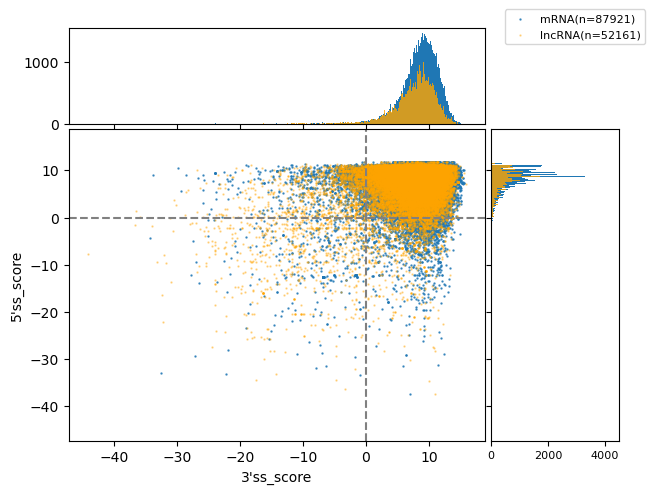

In [123]:
# 分布を確認

left, width = 0.1, 0.65 #散布図の左余白と、幅を定義
bottom, height = 0.1, 0.65 #散布図の下余白と、高さを定義
spacing = 0.01 #散布図とヒストグラムの間隔
fig_scatter = [left, bottom, width, height] #散布図の定義
fig_histx = [left, bottom + height + spacing, width, 0.2] #上のヒストグラムの定義
fig_histy = [left + width + spacing, bottom, 0.2, height] #右のヒストグラムの定義

fig = plt.figure() #描写領域を正方形で生成 figsize=(8, 8)

ax = fig.add_axes(fig_scatter) #図1として散布図領域を生成
ax_histx = fig.add_axes(fig_histx, sharex=ax) #上のヒストグラム領域を生成
ax_histy = fig.add_axes(fig_histy, sharey=ax) #右のヒストグラム領域を生成
ax_histx.tick_params(axis="x", labelbottom=False) #x軸ラベル無し
ax_histy.tick_params(axis="y", labelleft=False) #y軸ラベル無し

x1 = df_gencode_mRNA['3ss_score'].to_numpy()
y1 = df_gencode_mRNA['5ss_score'].to_numpy()
x2 = df_gencode_lncRNA['3ss_score'].to_numpy()
y2 = df_gencode_lncRNA['5ss_score'].to_numpy()

xmax = max(np.max(x1), np.max(x2))
ymax = max(np.max(y1), np.max(y2))
xymax = max(xmax, ymax)

xmin = min(np.min(x1), np.min(x2))
ymin = min(np.min(y1), np.min(y2))
xymin = min(xmin, ymin)

binwidth = 0.1 #binの値幅を定義。
bins = np.arange(xymin, xymax, binwidth) #binの個数を定義

#ax.set_xlim([0, xymax])
#ax.set_ylim([0, xymax])

ax.scatter(x1, y1, s=0.5, color='#1f77b4', alpha=0.8, label='mRNA(n='+str(len(x1))+')')
ax.scatter(x2, y2, s=0.5, color='orange', alpha=0.4, label='lncRNA(n='+str(len(x2))+')')

#ax.plot([0, xymax], [0, xymax], color='darkturquoise', linestyle='--', label='FC=1')
#ax.plot(bins, 1.5*bins, color='dodgerblue', linestyle='--', label='FC=1.5')
#ax.plot(bins, 2.0*bins, color='blue', linestyle='--', label='FC=2')

#r = df.loc[:, x_label:y_label].corr(method='pearson').iloc[0, 1]
#lm = LinearRegression().fit(x.reshape(-1, 1), y)
#ax.plot(x, lm.predict(x.reshape(-1, 1)), color='purple', linestyle='--', label='r='+str(round(r, 2)))

ax_histx.hist(x1, bins=bins, color='#1f77b4')
ax_histy.hist(y1, bins=bins, orientation='horizontal', color='#1f77b4')
ax_histx.hist(x2, bins=bins, color='orange', alpha=0.8)
ax_histy.hist(y2, bins=bins, orientation='horizontal', color='orange', alpha=0.8)

ax.set_xlabel('3\'ss_score')
ax.set_ylabel('5\'ss_score')

ax.axvline(0, color='gray', linestyle='--')
ax.axhline(0, color='gray', linestyle='--')

ax.legend(
    bbox_to_anchor=(1.4, 1.4),
    loc='upper right',
    #borderaxespad=0,
    fontsize=8
)

plt.tick_params(labelsize=8)
plt.show()
#plt.savefig(outfile)

In [148]:
ds_mRNA = df_gencode_mRNA.sample(10000, random_state=1)
ds_lncRNA = df_gencode_lncRNA.sample(10000, random_state=1)

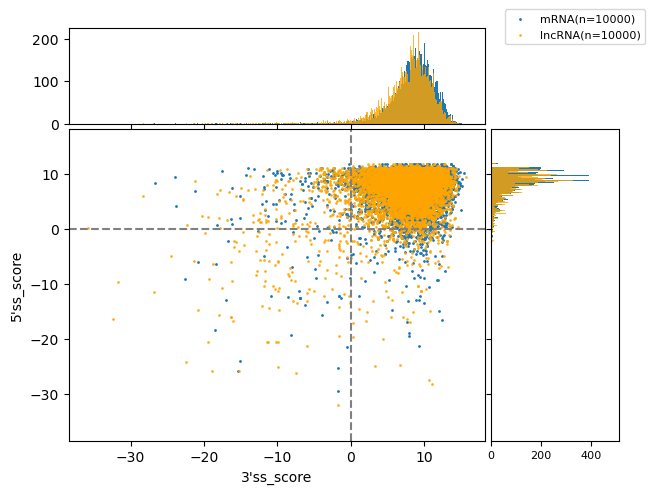

In [150]:
# 分布を確認

left, width = 0.1, 0.65 #散布図の左余白と、幅を定義
bottom, height = 0.1, 0.65 #散布図の下余白と、高さを定義
spacing = 0.01 #散布図とヒストグラムの間隔
fig_scatter = [left, bottom, width, height] #散布図の定義
fig_histx = [left, bottom + height + spacing, width, 0.2] #上のヒストグラムの定義
fig_histy = [left + width + spacing, bottom, 0.2, height] #右のヒストグラムの定義

fig = plt.figure() #描写領域を正方形で生成 figsize=(8, 8)

ax = fig.add_axes(fig_scatter) #図1として散布図領域を生成
ax_histx = fig.add_axes(fig_histx, sharex=ax) #上のヒストグラム領域を生成
ax_histy = fig.add_axes(fig_histy, sharey=ax) #右のヒストグラム領域を生成
ax_histx.tick_params(axis="x", labelbottom=False) #x軸ラベル無し
ax_histy.tick_params(axis="y", labelleft=False) #y軸ラベル無し

x1 = ds_mRNA['3ss_score'].to_numpy()
y1 = ds_mRNA['5ss_score'].to_numpy()
x2 = ds_lncRNA['3ss_score'].to_numpy()
y2 = ds_lncRNA['5ss_score'].to_numpy()

xmax = max(np.max(x1), np.max(x2))
ymax = max(np.max(y1), np.max(y2))
xymax = max(xmax, ymax)

xmin = min(np.min(x1), np.min(x2))
ymin = min(np.min(y1), np.min(y2))
xymin = min(xmin, ymin)

binwidth = 0.1 #binの値幅を定義。
bins = np.arange(xymin, xymax, binwidth) #binの個数を定義

#ax.set_xlim([0, xymax])
#ax.set_ylim([0, xymax])

ax.scatter(x1, y1, s=1.0, color='#1f77b4', alpha=1.0, label='mRNA(n='+str(len(x1))+')')
ax.scatter(x2, y2, s=1.0, color='orange', alpha=0.8, label='lncRNA(n='+str(len(x2))+')')

#ax.plot([0, xymax], [0, xymax], color='darkturquoise', linestyle='--', label='FC=1')
#ax.plot(bins, 1.5*bins, color='dodgerblue', linestyle='--', label='FC=1.5')
#ax.plot(bins, 2.0*bins, color='blue', linestyle='--', label='FC=2')

#r = df.loc[:, x_label:y_label].corr(method='pearson').iloc[0, 1]
#lm = LinearRegression().fit(x.reshape(-1, 1), y)
#ax.plot(x, lm.predict(x.reshape(-1, 1)), color='purple', linestyle='--', label='r='+str(round(r, 2)))

ax_histx.hist(x1, bins=bins, color='#1f77b4')
ax_histy.hist(y1, bins=bins, orientation='horizontal', color='#1f77b4')
ax_histx.hist(x2, bins=bins, color='orange', alpha=0.8)
ax_histy.hist(y2, bins=bins, orientation='horizontal', color='orange', alpha=0.8)

ax.set_xlabel('3\'ss_score')
ax.set_ylabel('5\'ss_score')

ax.axvline(0, color='gray', linestyle='--')
ax.axhline(0, color='gray', linestyle='--')

ax.legend(
    bbox_to_anchor=(1.4, 1.4),
    loc='upper right',
    #borderaxespad=0,
    fontsize=8
)

plt.tick_params(labelsize=8)
plt.show()
#plt.savefig(outfile)

In [158]:
ds_mRNA = df_gencode_mRNA.sample(10000, random_state=1)
ds_lncRNA = df_LncBook.sample(10000, random_state=1)

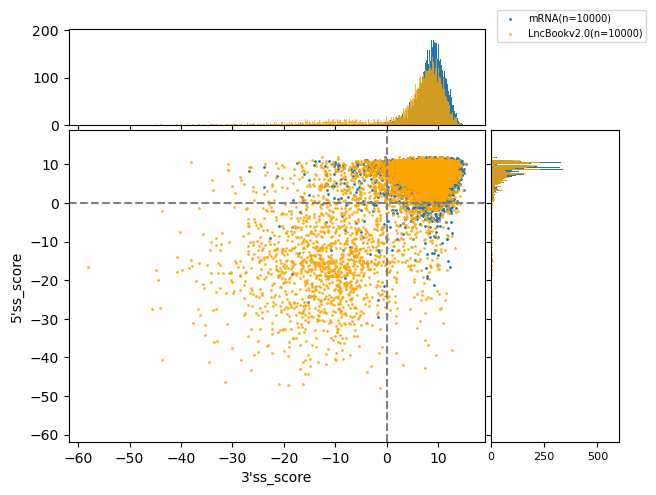

In [159]:
# 分布を確認

left, width = 0.1, 0.65 #散布図の左余白と、幅を定義
bottom, height = 0.1, 0.65 #散布図の下余白と、高さを定義
spacing = 0.01 #散布図とヒストグラムの間隔
fig_scatter = [left, bottom, width, height] #散布図の定義
fig_histx = [left, bottom + height + spacing, width, 0.2] #上のヒストグラムの定義
fig_histy = [left + width + spacing, bottom, 0.2, height] #右のヒストグラムの定義

fig = plt.figure() #描写領域を正方形で生成 figsize=(8, 8)

ax = fig.add_axes(fig_scatter) #図1として散布図領域を生成
ax_histx = fig.add_axes(fig_histx, sharex=ax) #上のヒストグラム領域を生成
ax_histy = fig.add_axes(fig_histy, sharey=ax) #右のヒストグラム領域を生成
ax_histx.tick_params(axis="x", labelbottom=False) #x軸ラベル無し
ax_histy.tick_params(axis="y", labelleft=False) #y軸ラベル無し

x1 = ds_mRNA['3ss_score'].to_numpy()
y1 = ds_mRNA['5ss_score'].to_numpy()
x2 = ds_lncRNA['3ss_score'].to_numpy()
y2 = ds_lncRNA['5ss_score'].to_numpy()

xmax = max(np.max(x1), np.max(x2))
ymax = max(np.max(y1), np.max(y2))
xymax = max(xmax, ymax)

xmin = min(np.min(x1), np.min(x2))
ymin = min(np.min(y1), np.min(y2))
xymin = min(xmin, ymin)

binwidth = 0.1 #binの値幅を定義。
bins = np.arange(xymin, xymax, binwidth) #binの個数を定義

#ax.set_xlim([0, xymax])
#ax.set_ylim([0, xymax])

ax.scatter(x1, y1, s=1.0, color='#1f77b4', alpha=1.0, label='mRNA(n='+str(len(x1))+')')
ax.scatter(x2, y2, s=1.0, color='orange', alpha=0.8, label='LncBookv2.0(n='+str(len(x2))+')')

#ax.plot([0, xymax], [0, xymax], color='darkturquoise', linestyle='--', label='FC=1')
#ax.plot(bins, 1.5*bins, color='dodgerblue', linestyle='--', label='FC=1.5')
#ax.plot(bins, 2.0*bins, color='blue', linestyle='--', label='FC=2')

#r = df.loc[:, x_label:y_label].corr(method='pearson').iloc[0, 1]
#lm = LinearRegression().fit(x.reshape(-1, 1), y)
#ax.plot(x, lm.predict(x.reshape(-1, 1)), color='purple', linestyle='--', label='r='+str(round(r, 2)))

ax_histx.hist(x1, bins=bins, color='#1f77b4')
ax_histy.hist(y1, bins=bins, orientation='horizontal', color='#1f77b4')
ax_histx.hist(x2, bins=bins, color='orange', alpha=0.8)
ax_histy.hist(y2, bins=bins, orientation='horizontal', color='orange', alpha=0.8)

ax.set_xlabel('3\'ss_score')
ax.set_ylabel('5\'ss_score')

ax.axvline(0, color='gray', linestyle='--')
ax.axhline(0, color='gray', linestyle='--')

ax.legend(
    bbox_to_anchor=(1.4, 1.4),
    loc='upper right',
    #borderaxespad=0,
    fontsize=7
)

plt.tick_params(labelsize=8)
plt.show()
#plt.savefig(outfile)

In [155]:
ds_mRNA = df_gencode_mRNA.sample(10000, random_state=1)
ds_lncRNA = df_gencode_lncRNA.sample(10000, random_state=1)
ds_lncBook = df_LncBook.sample(10000, random_state=1)

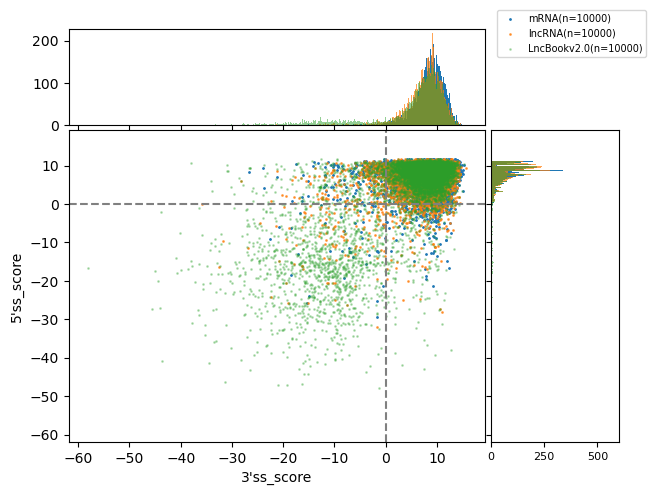

In [156]:
# 分布を確認

left, width = 0.1, 0.65 #散布図の左余白と、幅を定義
bottom, height = 0.1, 0.65 #散布図の下余白と、高さを定義
spacing = 0.01 #散布図とヒストグラムの間隔
fig_scatter = [left, bottom, width, height] #散布図の定義
fig_histx = [left, bottom + height + spacing, width, 0.2] #上のヒストグラムの定義
fig_histy = [left + width + spacing, bottom, 0.2, height] #右のヒストグラムの定義

fig = plt.figure() #描写領域を正方形で生成 figsize=(8, 8)

ax = fig.add_axes(fig_scatter) #図1として散布図領域を生成
ax_histx = fig.add_axes(fig_histx, sharex=ax) #上のヒストグラム領域を生成
ax_histy = fig.add_axes(fig_histy, sharey=ax) #右のヒストグラム領域を生成
ax_histx.tick_params(axis="x", labelbottom=False) #x軸ラベル無し
ax_histy.tick_params(axis="y", labelleft=False) #y軸ラベル無し

x1 = ds_mRNA['3ss_score'].to_numpy()
y1 = ds_mRNA['5ss_score'].to_numpy()
x2 = ds_lncRNA['3ss_score'].to_numpy()
y2 = ds_lncRNA['5ss_score'].to_numpy()
x3 = ds_lncBook['3ss_score'].to_numpy()
y3 = ds_lncBook['5ss_score'].to_numpy()

xmax = max(np.max(x1), np.max(x2), np.max(x3))
ymax = max(np.max(y1), np.max(y2), np.max(y3))
xymax = max(xmax, ymax)

xmin = min(np.min(x1), np.min(x2), np.min(x3))
ymin = min(np.min(y1), np.min(y2), np.min(y3))
xymin = min(xmin, ymin)

binwidth = 0.1 #binの値幅を定義。
bins = np.arange(xymin, xymax, binwidth) #binの個数を定義

#ax.set_xlim([0, xymax])
#ax.set_ylim([0, xymax])

ax.scatter(x1, y1, s=1.0, color='#1f77b4', alpha=1.0, label='mRNA(n='+str(len(x1))+')')
ax.scatter(x2, y2, s=1.0, color='#ff7f0e', alpha=0.7, label='lncRNA(n='+str(len(x2))+')')
ax.scatter(x3, y3, s=1.0, color='#2ca02c', alpha=0.3, label='LncBookv2.0(n='+str(len(x3))+')')

#ax.plot([0, xymax], [0, xymax], color='darkturquoise', linestyle='--', label='FC=1')
#ax.plot(bins, 1.5*bins, color='dodgerblue', linestyle='--', label='FC=1.5')
#ax.plot(bins, 2.0*bins, color='blue', linestyle='--', label='FC=2')

#r = df.loc[:, x_label:y_label].corr(method='pearson').iloc[0, 1]
#lm = LinearRegression().fit(x.reshape(-1, 1), y)
#ax.plot(x, lm.predict(x.reshape(-1, 1)), color='purple', linestyle='--', label='r='+str(round(r, 2)))

ax_histx.hist(x1, bins=bins, color='#1f77b4', alpha=1.0)
ax_histy.hist(y1, bins=bins, orientation='horizontal', color='#1f77b4', alpha=1.0)
ax_histx.hist(x2, bins=bins, color='#ff7f0e', alpha=0.7)
ax_histy.hist(y2, bins=bins, orientation='horizontal', color='#ff7f0e', alpha=0.7)
ax_histx.hist(x3, bins=bins, color='#2ca02c', alpha=0.5)
ax_histy.hist(y3, bins=bins, orientation='horizontal', color='#2ca02c', alpha=0.5)

ax.set_xlabel('3\'ss_score')
ax.set_ylabel('5\'ss_score')

ax.axvline(0, color='gray', linestyle='--')
ax.axhline(0, color='gray', linestyle='--')

ax.legend(
    bbox_to_anchor=(1.4, 1.4),
    loc='upper right',
    #borderaxespad=0,
    fontsize=7
)

plt.tick_params(labelsize=8)
plt.show()
#plt.savefig(outfile)

```bash
touchiyama:14:00:17:@Mac:~/lncRNA/reference $ wget https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_43/gencode.v43.pc_transcripts.fa.gz
touchiyama:14:01:07:@Mac:~/lncRNA/reference $ wget https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_43/gencode.v43.lncRNA_transcripts.fa.gz
touchiyama:14:05:33:@Mac:~/lncRNA/reference $ wget https://ngdc.cncb.ac.cn/lncbook/files/lncRNA_LncBookv2.0.fa.gz
```

```bash
touchiyama:14:10:10:@Mac:~/lncRNA/reference $ brew install gffread

touchiyama:14:40:06:@Mac:~/lncRNA/reference $ head -n 10 list
chr1
chr2
chr3
chr4
chr5
chr6
chr7
chr8
chr9
chr10

touchiyama:14:37:39:@Mac:~/lncRNA/reference $ seqkit grep -f list GRCh38.primary_assembly.genome.fa.gz > GRCh38_ex_contig.fa
touchiyama:14:52:09:@Mac:~/lncRNA/reference $ gffread -g GRCh38_ex_contig.fa -x gencode.v43.cds.fa gencode.v43.annotation.gtf
FASTA index file GRCh38_ex_contig.fa.fai created.
Warning: CDS 96797247-96797249 too short for ENST00000503921.5, check your data.
Warning: CDS 136153761-136153763 too short for ENST00000515005.1, check your data.
Warning: CDS 98883754-98883756 too short for ENST00000519420.1, check your data.
Warning: CDS 89405454-89405456 too short for ENST00000420670.5, check your data.
Warning: CDS 59737198-59737200 too short for ENST00000602051.5, check your data.
Warning: CDS 59737198-59737200 too short for ENST00000599605.1, check your data.
Warning: CDS 35317504-35317506 too short for ENST00000645966.1, check your data.
Warning: CDS 79069942-79069944 too short for ENST00000527736.5, check your data.
Warning: CDS 126290895-126290897 too short for ENST00000467006.6, check your data.
Warning: CDS 51662818-51662820 too short for ENST00000546961.1, check your data.
Warning: CDS 18355979-18355981 too short for ENST00000583780.1, check your data.
Warning: CDS 41988476-41988478 too short for ENST00000636197.1, check your data.

touchiyama:14:56:22:@Mac:~/lncRNA/reference $ gzip GRCh38_ex_contig.fa
touchiyama:14:56:57:@Mac:~/lncRNA/reference $ gzip gencode.v43.cds.fa
touchiyama:14:54:43:@Mac:~/lncRNA/reference $ rm GRCh38.primary_assembly.genome.fa.gz
```

```bash
# import sys -> lncDC-train.pyに入れる
touchiyama:15:03:12:@Mac:~/lncRNA/LncDC/bin $ conda install -c bioconda viennarna
import viennarna as RNA
```

## RandomUnderSampler + SMOTE

In [162]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [181]:
def under_over_process(x, y, njobs):
    ratio = y.value_counts()[0] / y.value_counts()[1]
    # undersample first
    seed = 1234
    if(ratio < 2/3 or ratio > 1.5):
        print('Undersample')
        rus = RandomUnderSampler(sampling_strategy=2/3,random_state=seed)
        x_underSampled, y_underSampled = rus.fit_resample(x, y)
    else:
        print('normal')
        x_underSampled = x
        y_underSampled = y

    # then oversample
    print('SMOTE')
    smote = SMOTE(random_state=seed, n_jobs = njobs)
    x_resampled, y_resampled = smote.fit_resample(x_underSampled, y_underSampled)
    return x_resampled, y_resampled


In [165]:
print(df_gencode_mRNA.index.size)
print(df_gencode_lncRNA.index.size)
print(df_LncBook.index.size)

87921
52161
286715


In [168]:
df_gencode_mRNA['type'] = 'mrna'
df_gencode_lncRNA['type'] = 'lncrna'
df_LncBook['type'] = 'lncrna'

In [170]:
df_gencode_mRNA.head()

,transcript_id,strand,pos_x,5ss_seq,5ss_score,pos_y,3ss_seq,3ss_score,type
0,ENST00000641515.2,+,chr1_65431-65439:.,CAGGTACAT,7.79,chr1_65500-65522:.,TACATATTATTCTCTTACAGTTT,9.11,mrna
1,ENST00000616016.5,+,chr1_924946-924954:.,AAGGTGCCG,5.74,chr1_925902-925924:.,TGCCTCGGCTCTGCTCGCAGGGA,9.26,mrna
2,ENST00000618323.5,+,chr1_924946-924954:.,AAGGTGCCG,5.74,chr1_925902-925924:.,TGCCTCGGCTCTGCTCGCAGGGA,9.26,mrna
3,ENST00000437963.5,+,chr1_925187-925195:.,AAGGTCTCT,0.90,chr1_925902-925924:.,TGCCTCGGCTCTGCTCGCAGGGA,9.26,mrna
4,ENST00000342066.8,+,chr1_925798-925806:.,GAGGTGGGT,7.07,chr1_925902-925924:.,TGCCTCGGCTCTGCTCGCAGGGA,9.26,mrna


In [171]:
df_gencode_lncRNA.head()

,transcript_id,strand,pos_x,5ss_seq,5ss_score,pos_y,3ss_seq,3ss_score,type
0,ENST00000456328.2,+,chr1_12225-12233:.,CCAGTAAGT,9.09,chr1_12593-12615:.,AGGCTCCTGTCTCCCCCCAGGTG,11.90,lncrna
1,ENST00000473358.1,+,chr1_30037-30045:.,TGGGTAGAG,-1.16,chr1_30544-30566:.,ACACTCTCTCCCTCTCCCAGTTT,9.51,lncrna
2,ENST00000469289.1,+,chr1_30665-30673:.,GAGGTAAAG,8.27,chr1_30956-30978:.,CTCTGTCTTTTCCCACCAAGTGA,4.48,lncrna
3,ENST00000642116.1,+,chr1_57651-57659:.,CAGGTAAAA,8.59,chr1_58680-58702:.,AAATTTTAAATCTCCAATAGGAA,6.27,lncrna
4,ENST00000496488.1,+,chr1_160688-160696:.,CAGGTACAT,7.79,chr1_161294-161316:.,ACTGTGTTCTCTACTAAAAGGAA,7.22,lncrna


In [169]:
df_LncBook.head()

,transcript_id,strand,pos_x,5ss_seq,5ss_score,pos_y,3ss_seq,3ss_score,type
0,HSALNT0000008,+,chr1_30037-30045:.,TGGGTAGAG,-1.16,chr1_30544-30566:.,ACACTCTCTCCCTCTCCCAGTTT,9.51,lncrna
1,HSALNT0000010,+,chr1_30665-30673:.,GAGGTAAAG,8.27,chr1_30956-30978:.,CTCTGTCTTTTCCCACCAAGTGA,4.48,lncrna
2,HSALNT0289525,+,chr1_30037-30045:.,TGGGTAGAG,-1.16,chr1_30544-30566:.,ACACTCTCTCCCTCTCCCAGTTT,9.51,lncrna
3,HSALNT0289527,+,chr1_51992-52000:.,TGGGTGAGT,8.73,chr1_53262-53284:.,TTGCTATCACCCCTGTCTAGGAT,7.70,lncrna
4,HSALNT0289534,+,chr1_96808-96816:.,GGAGTAAGT,8.57,chr1_106616-106638:.,TATGTTTTCCCCTAACTCAGGGT,7.34,lncrna


## Undersampling with SMOTE between gencode.mRNA and gencode.lncRNA

In [172]:
# combine to a single dataframe
df_gencode = pd.concat([df_gencode_mRNA, df_gencode_lncRNA])
df_gencode.reset_index(drop=True, inplace=True)

In [177]:
df_gencode.iloc[87919:87923, :]

,transcript_id,strand,pos_x,5ss_seq,5ss_score,pos_y,3ss_seq,3ss_score,type
87919,ENST00000618574.1,-,chrY_25043940-25043948:.,CAGGTACTA,7.64,chrY_25041884-25041906:.,AATGTGGCCCTCTTTCCTAGGTG,9.47,mrna
87920,ENST00000602680.1,-,chrY_25062387-25062395:.,TAGGTATGT,7.76,chrY_25052217-25052239:.,TCTCTATGCCTATCACCTAGGTG,7.24,mrna
87921,ENST00000456328.2,+,chr1_12225-12233:.,CCAGTAAGT,9.09,chr1_12593-12615:.,AGGCTCCTGTCTCCCCCCAGGTG,11.90,lncrna
87922,ENST00000473358.1,+,chr1_30037-30045:.,TGGGTAGAG,-1.16,chr1_30544-30566:.,ACACTCTCTCCCTCTCCCAGTTT,9.51,lncrna


In [203]:
# balancing training data
x_resamp_gencode, y_resamp_gencode = under_over_process(
    df_gencode[['3ss_score', '5ss_score']],
    df_gencode['type'],
    1
)
#y_resampled = y_resampled.map({'mrna':1,'lncrna':0})

Undersample
SMOTE


/Users/tomoyauchiyama/.pyenv/versions/anaconda3-2023.03/lib/python3.10/site-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [204]:
y_resamp_gencode.value_counts()

lncrna    78241
mrna      78241
Name: type, dtype: int64

In [205]:
y_resamp_gencode.head()

0    lncrna
1    lncrna
2    lncrna
3    lncrna
4    lncrna
Name: type, dtype: object

In [192]:
x_resamp_gencode.head()

,3ss_score,5ss_score
0,11.90,9.09
1,9.51,-1.16
2,4.48,8.27
3,6.27,8.59
4,7.22,7.79


In [206]:
xy_resamp_gencode = pd.concat([x_resamp_gencode, y_resamp_gencode], axis=1)
xy_resamp_gencode.head()

,3ss_score,5ss_score,type
0,11.90,9.09,lncrna
1,9.51,-1.16,lncrna
2,4.48,8.27,lncrna
3,6.27,8.59,lncrna
4,7.22,7.79,lncrna


In [ ]:
xy_resamp_gencode[]

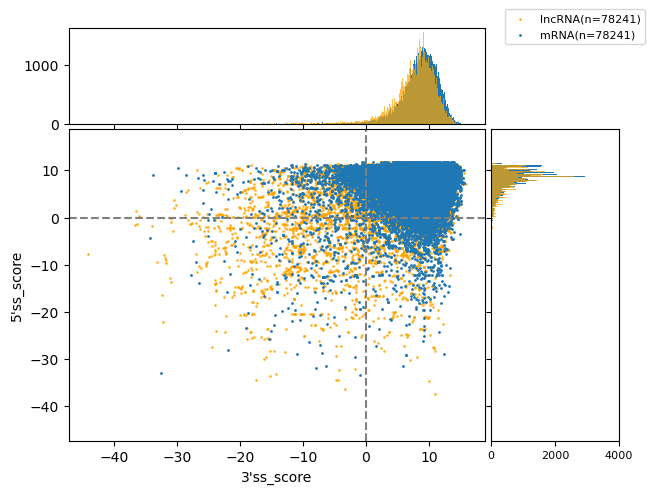

In [214]:
# 分布を確認
left, width = 0.1, 0.65 #散布図の左余白と、幅を定義
bottom, height = 0.1, 0.65 #散布図の下余白と、高さを定義
spacing = 0.01 #散布図とヒストグラムの間隔
fig_scatter = [left, bottom, width, height] #散布図の定義
fig_histx = [left, bottom + height + spacing, width, 0.2] #上のヒストグラムの定義
fig_histy = [left + width + spacing, bottom, 0.2, height] #右のヒストグラムの定義

fig = plt.figure() #描写領域を正方形で生成 figsize=(8, 8)

ax = fig.add_axes(fig_scatter) #図1として散布図領域を生成
ax_histx = fig.add_axes(fig_histx, sharex=ax) #上のヒストグラム領域を生成
ax_histy = fig.add_axes(fig_histy, sharey=ax) #右のヒストグラム領域を生成
ax_histx.tick_params(axis="x", labelbottom=False) #x軸ラベル無し
ax_histy.tick_params(axis="y", labelleft=False) #y軸ラベル無し

x1 = xy_resamp_gencode[xy_resamp_gencode['type'] == 'mrna']['3ss_score'].to_numpy()
y1 = xy_resamp_gencode[xy_resamp_gencode['type'] == 'mrna']['5ss_score'].to_numpy()
x2 = xy_resamp_gencode[xy_resamp_gencode['type'] == 'lncrna']['3ss_score'].to_numpy()
y2 = xy_resamp_gencode[xy_resamp_gencode['type'] == 'lncrna']['5ss_score'].to_numpy()

xmax = max(np.max(x1), np.max(x2))
ymax = max(np.max(y1), np.max(y2))
xymax = max(xmax, ymax)

xmin = min(np.min(x1), np.min(x2))
ymin = min(np.min(y1), np.min(y2))
xymin = min(xmin, ymin)

binwidth = 0.1 #binの値幅を定義。
bins = np.arange(xymin, xymax, binwidth) #binの個数を定義

#ax.set_xlim([0, xymax])
#ax.set_ylim([0, xymax])

ax.scatter(x2, y2, s=1.0, color='orange', alpha=0.7, label='lncRNA(n='+str(len(x2))+')')
ax.scatter(x1, y1, s=1.0, color='#1f77b4', alpha=1.0, label='mRNA(n='+str(len(x1))+')')


#ax.plot([0, xymax], [0, xymax], color='darkturquoise', linestyle='--', label='FC=1')
#ax.plot(bins, 1.5*bins, color='dodgerblue', linestyle='--', label='FC=1.5')
#ax.plot(bins, 2.0*bins, color='blue', linestyle='--', label='FC=2')

#r = df.loc[:, x_label:y_label].corr(method='pearson').iloc[0, 1]
#lm = LinearRegression().fit(x.reshape(-1, 1), y)
#ax.plot(x, lm.predict(x.reshape(-1, 1)), color='purple', linestyle='--', label='r='+str(round(r, 2)))

ax_histx.hist(x1, bins=bins, color='#1f77b4')
ax_histy.hist(y1, bins=bins, orientation='horizontal', color='#1f77b4')
ax_histx.hist(x2, bins=bins, color='orange', alpha=0.7)
ax_histy.hist(y2, bins=bins, orientation='horizontal', color='orange', alpha=0.7)

ax.set_xlabel('3\'ss_score')
ax.set_ylabel('5\'ss_score')

ax.axvline(0, color='gray', linestyle='--')
ax.axhline(0, color='gray', linestyle='--')

ax.legend(
    bbox_to_anchor=(1.4, 1.4),
    loc='upper right',
    #borderaxespad=0,
    fontsize=8
)

plt.tick_params(labelsize=8)
plt.show()
#plt.savefig(outfile)

In [225]:
mrna = xy_resamp_gencode[xy_resamp_gencode['type'] == 'mrna'][['3ss_score', '5ss_score']]
lncrna = xy_resamp_gencode[xy_resamp_gencode['type'] == 'lncrna'][['3ss_score', '5ss_score']]
print(len(mrna[(mrna['3ss_score'] < 0) & (mrna['5ss_score'] < 0)]))
print(len(lncrna[(lncrna['3ss_score'] < 0) & (lncrna['5ss_score'] < 0)]))

312
955


## Undersampling with SMOTE between gencode.mRNA and LncBookv2.0.lncRNA

In [193]:
# combine to a single dataframe
df_genlncB = pd.concat([df_gencode_mRNA, df_LncBook])
df_genlncB.reset_index(drop=True, inplace=True)

In [194]:
# balancing training data
x_resamp_genlncB, y_resamp_genlncB = under_over_process(
    df_genlncB[['3ss_score', '5ss_score']],
    df_genlncB['type'],
    1
)

Undersample
SMOTE


/Users/tomoyauchiyama/.pyenv/versions/anaconda3-2023.03/lib/python3.10/site-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [195]:
y_resamp_genlncB.value_counts()

lncrna    131881
mrna      131881
Name: type, dtype: int64

In [197]:
y_resamp_genlncB.head()

0    lncrna
1    lncrna
2    lncrna
3    lncrna
4    lncrna
Name: type, dtype: object

In [196]:
x_resamp_genlncB.head()

,3ss_score,5ss_score
0,4.27,9.14
1,8.32,10.24
2,-7.93,9.11
3,8.56,9.60
4,3.42,5.13


In [207]:
xy_resamp_genlncB = pd.concat([x_resamp_genlncB, y_resamp_genlncB], axis=1)
xy_resamp_genlncB.head()

,3ss_score,5ss_score,type
0,4.27,9.14,lncrna
1,8.32,10.24,lncrna
2,-7.93,9.11,lncrna
3,8.56,9.60,lncrna
4,3.42,5.13,lncrna


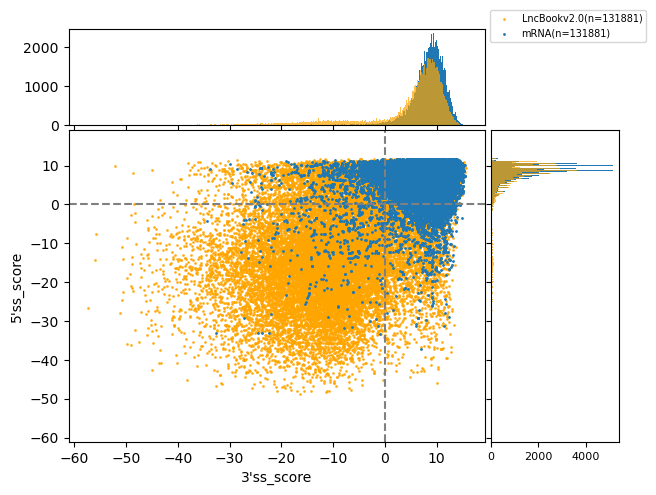

In [213]:
# 分布を確認

left, width = 0.1, 0.65 #散布図の左余白と、幅を定義
bottom, height = 0.1, 0.65 #散布図の下余白と、高さを定義
spacing = 0.01 #散布図とヒストグラムの間隔
fig_scatter = [left, bottom, width, height] #散布図の定義
fig_histx = [left, bottom + height + spacing, width, 0.2] #上のヒストグラムの定義
fig_histy = [left + width + spacing, bottom, 0.2, height] #右のヒストグラムの定義

fig = plt.figure() #描写領域を正方形で生成 figsize=(8, 8)

ax = fig.add_axes(fig_scatter) #図1として散布図領域を生成
ax_histx = fig.add_axes(fig_histx, sharex=ax) #上のヒストグラム領域を生成
ax_histy = fig.add_axes(fig_histy, sharey=ax) #右のヒストグラム領域を生成
ax_histx.tick_params(axis="x", labelbottom=False) #x軸ラベル無し
ax_histy.tick_params(axis="y", labelleft=False) #y軸ラベル無し

x1 = xy_resamp_genlncB[xy_resamp_genlncB['type'] == 'mrna']['3ss_score'].to_numpy()
y1 = xy_resamp_genlncB[xy_resamp_genlncB['type'] == 'mrna']['5ss_score'].to_numpy()
x2 = xy_resamp_genlncB[xy_resamp_genlncB['type'] == 'lncrna']['3ss_score'].to_numpy()
y2 = xy_resamp_genlncB[xy_resamp_genlncB['type'] == 'lncrna']['5ss_score'].to_numpy()

xmax = max(np.max(x1), np.max(x2))
ymax = max(np.max(y1), np.max(y2))
xymax = max(xmax, ymax)

xmin = min(np.min(x1), np.min(x2))
ymin = min(np.min(y1), np.min(y2))
xymin = min(xmin, ymin)

binwidth = 0.1 #binの値幅を定義。
bins = np.arange(xymin, xymax, binwidth) #binの個数を定義

#ax.set_xlim([0, xymax])
#ax.set_ylim([0, xymax])


ax.scatter(x2, y2, s=1.0, color='orange', alpha=0.8, label='LncBookv2.0(n='+str(len(x2))+')')
ax.scatter(x1, y1, s=1.0, color='#1f77b4', alpha=1.0, label='mRNA(n='+str(len(x1))+')')

#ax.plot([0, xymax], [0, xymax], color='darkturquoise', linestyle='--', label='FC=1')
#ax.plot(bins, 1.5*bins, color='dodgerblue', linestyle='--', label='FC=1.5')
#ax.plot(bins, 2.0*bins, color='blue', linestyle='--', label='FC=2')

#r = df.loc[:, x_label:y_label].corr(method='pearson').iloc[0, 1]
#lm = LinearRegression().fit(x.reshape(-1, 1), y)
#ax.plot(x, lm.predict(x.reshape(-1, 1)), color='purple', linestyle='--', label='r='+str(round(r, 2)))

ax_histx.hist(x1, bins=bins, color='#1f77b4')
ax_histy.hist(y1, bins=bins, orientation='horizontal', color='#1f77b4')
ax_histx.hist(x2, bins=bins, color='orange', alpha=0.7)
ax_histy.hist(y2, bins=bins, orientation='horizontal', color='orange', alpha=0.7)

ax.set_xlabel('3\'ss_score')
ax.set_ylabel('5\'ss_score')

ax.axvline(0, color='gray', linestyle='--')
ax.axhline(0, color='gray', linestyle='--')

ax.legend(
    bbox_to_anchor=(1.4, 1.4),
    loc='upper right',
    #borderaxespad=0,
    fontsize=7
)

plt.tick_params(labelsize=8)
plt.show()
#plt.savefig(outfile)

In [226]:
mrna = xy_resamp_genlncB[xy_resamp_genlncB['type'] == 'mrna'][['3ss_score', '5ss_score']]
lncrna = xy_resamp_genlncB[xy_resamp_genlncB['type'] == 'lncrna'][['3ss_score', '5ss_score']]
print(len(mrna[(mrna['3ss_score'] < 0) & (mrna['5ss_score'] < 0)]))
print(len(lncrna[(lncrna['3ss_score'] < 0) & (lncrna['5ss_score'] < 0)]))

521
16405
